In [ ]:
# ARIMA MODEL
# Fit an ARIMA model.

# There are three hyperparameters we need to get values for when fitting an ARIMA model.
# Determine a value of  using the Augmented Dickey-Fuller test.

# Then, determine values of  and  through GridSearching.

# An  model is specified by:
# -how many differences  we need to calculate in order to achieve stationarity.
# -how many lags  we regress  on.
# -how many errors  we regress  on.


# Depending on our values of , , and , we might refer to these models by slightly different names.
# If  and , an AR(p) model is specified by how many lags  we regress  on.
# If  and , an MA(q) model is specified by how many errors  we regress  on.
# If , an ARMA(p, q) model is specified by how many lags  and how many errors  we regress  on.

### Takeaways

- Stationary Time Series
> Stationary Time Series has no predictable patterns in the long term <br>
> and will show the series to be roughly horizontal in time plots with <br>
> constant variance<br><br>
> A time series with cyclic behavior, but no trend or seasonality is stationary.
> Because the cycles are not of a fixed length.

- Differencing
> When we compute the differences between observations to make a non-stationary <br>
> time series stationary.<br>
> ACF plot (auto correlation function plot) is useful for identifying non-stationary time series<br><br>
> in a stationary time series, the ACF drops to zero relatively quickly, <br>
> while the ACF of a non-stationary data decreases slowly. <br><br>
> For non-stationary data, the value of r1 is often large and positive

- Differenced Series
> The change between consecutive observations in the original series.<br>
> Differenced series will only have t-1 values since its not possible <br>
> to calculate the first observation.

- Random Walk Models
> Widely used for non-stationary data, particularly financial and economic data.<br>
> Random walks typically have long periods of apparent trends up or down and sudden<br>
> and unpredictable changes in direction.

In [1]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.pipeline import Pipeline
import pymssql
import pandas as pd
import datetime as dt
import plotly.express as px

In [2]:

database = "arctic_analysts_capstone"
user = "arctic_analysts"
password  = "ThisPassw0rd!"
server = "gen10-data-fundamentals-22-02-sql-server.database.windows.net"

def sql_query(query):
    conn = pymssql.connect(server, user, password, database)
    cursor = conn.cursor()
    queried_data = pd.read_sql(query, conn)
    return queried_data

In [3]:
def run_queries():
    tables = ["year", "month", "county", "median_income", "main_table"]

    query = f"SELECT * FROM {tables[0]}"
    year_df = sql_query(query)

    query = f"SELECT * FROM {tables[1]}"
    month_df = sql_query(query)

    query = f"SELECT * FROM {tables[2]}"
    county_df = sql_query(query)

    query = f"SELECT * FROM {tables[3]}"
    median_income_df = sql_query(query)

    query = f"SELECT * FROM {tables[4]}"
    main_table = sql_query(query)

    all_df = [year_df, month_df, county_df, median_income_df, main_table]
    return all_df

In [4]:
def join_tables(all_df):
    year_df = all_df[0]
    month_df = all_df[1]
    county_df = all_df[2]
    median_income_df = all_df[3]
    main_table = all_df[4]

    master_table = pd.merge(
        main_table, year_df, left_on="YearID", right_on="YearID", how="outer"
    )
    print(master_table.shape[0])
    # Now has 5607 rows

    master_table = pd.merge(
        master_table, month_df, left_on="MonthID", right_on="MonthID", how="outer"
    )
    # Now has 5607 rows
    print(master_table.shape[0])

    master_table = pd.merge(
        master_table, county_df, left_on="FIPS", right_on="FIPS", how="outer"
    )
    # Now has 5607 rows
    print(master_table.shape[0])

    master_table = pd.merge(
        master_table,
        median_income_df,
        left_on=["FIPS", "YearID"],
        right_on=["FIPS", "YearID"],
        how="outer",
    )
    # Now has 20727 rows
    print(master_table.shape[0])

    master_table.loc[(master_table.MedianIncome < 0), "MedianIncome"] = None
    return master_table

In [5]:
all_df = run_queries()

In [6]:
master_table = join_tables(all_df)

5607
5607
5607
20727


In [7]:
master_table

,FIPS,YearID,MonthID,NewUnits,NewBuildings,MedianHousePrice,AverageRate,AveragePoints,Year,Month,County,AgeGroup,MedianIncome
0,34001,1,1,66,66,136880.0,8.21,1.0,2000,Jan,Atlantic County,NaN,NaN
1,34001,1,2,110,110,137379.0,8.33,1.0,2000,Feb,Atlantic County,NaN,NaN
2,34001,1,3,98,87,137794.0,8.24,1.0,2000,Mar,Atlantic County,NaN,NaN
3,34001,1,4,90,90,138680.0,8.15,1.0,2000,Apr,Atlantic County,NaN,NaN
4,34001,1,5,121,121,139644.0,8.52,1.0,2000,May,Atlantic County,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20722,34041,22,11,26,14,334266.0,3.07,0.7,2021,Nov,Warren County,NaN,NaN
20723,34041,22,12,19,18,336388.0,3.10,0.6,2021,Dec,Warren County,NaN,NaN
20724,34041,23,1,13,12,338845.0,3.45,0.7,2022,Jan,Warren County,NaN,NaN
20725,34041,23,2,29,18,340046.0,3.76,0.8,2022,Feb,Warren County,NaN,NaN


In [99]:
house_price_df = master_table[['MedianHousePrice','Year', 'Month', 'MonthID','FIPS']].copy()

house_price_df = house_price_df[(house_price_df['FIPS'] == '34001')]

house_price_df.sort_values(by = ['Year', 'MonthID'], ascending = [True, True], inplace = True)

def convert_to_date(year, month):
    date = dt.datetime.strptime(f"{year}-{month}", "%Y-%b")#.date()
    #date = dt.datetime.strftime(date, "%Y-%m")
    return date

# Create a date to pass into the index for the model
house_price_df['date'] = house_price_df.apply(lambda row: convert_to_date(row.Year, row.Month), axis = 1)

# Get only the relevant columns
house_price_df = house_price_df[['MedianHousePrice', 'date']]

# Set the index as the date for the squeeze to series
house_price_df.set_index('date', inplace = True)

series = house_price_df.squeeze()

# Set the index as a period array
series.index = series.index.to_period('M')

house_price_df.describe()

,MedianHousePrice
count,987.000000
mean,231404.531915
std,43097.853200
min,136880.000000
25%,202862.000000
50%,213595.000000
75%,258515.000000
max,318877.000000


In [104]:
series

date
2000-01    136880.0
2000-02    137379.0
2000-03    137794.0
2000-04    138680.0
2000-05    139644.0
             ...   
2021-11    291523.0
2021-12    294593.0
2022-01    298233.0
2022-02    303616.0
2022-03    309748.0
Freq: M, Name: MedianHousePrice, Length: 987, dtype: float64

In [105]:
from statsmodels.tsa.stattools import adfuller

In [106]:
adfuller

<function statsmodels.tsa.stattools.adfuller(x, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)>

In [107]:
adfuller(series)

(-1.418810051406821,
 0.573225864755095,
 21,
 965,
 {'1%': -3.4371445907959832,
  '5%': -2.864539720789528,
  '10%': -2.5683672133480093},
 14629.565538304234)

In [ ]:
# fail to reject the null because the pvalue is high

In [122]:
df

,MedianHousePrice,first_diff_mhp,second_diff_mhp
date,,,
2000-01,136880.0,NaN,NaN
2000-02,137379.0,499.0,NaN
2000-03,137794.0,415.0,-84.0
2000-04,138680.0,886.0,471.0
2000-05,139644.0,964.0,78.0
...,...,...,...
2021-11,291523.0,1427.0,-2072.0
2021-12,294593.0,3070.0,1643.0
2022-01,298233.0,3640.0,570.0


In [109]:
df.set_index('date', inplace = True)

In [111]:
df['first_diff_mhp'] = df['MedianHousePrice'].diff()

In [116]:
df['second_diff_mhp'] = df['MedianHousePrice'].diff().diff()

In [117]:
df

,MedianHousePrice,first_diff_mhp,second_diff_mhp
date,,,
2000-01,136880.0,NaN,NaN
2000-02,137379.0,499.0,NaN
2000-03,137794.0,415.0,-84.0
2000-04,138680.0,886.0,471.0
2000-05,139644.0,964.0,78.0
...,...,...,...
2021-11,291523.0,1427.0,-2072.0
2021-12,294593.0,3070.0,1643.0
2022-01,298233.0,3640.0,570.0


In [114]:
adfuller(df['first_diff_mhp'].dropna())

(-1.4375807052154124,
 0.5641328241575112,
 22,
 963,
 {'1%': -3.4371587399783072,
  '5%': -2.8645459603872903,
  '10%': -2.568370536787406},
 14613.60489046329)

In [118]:
adfuller(df['second_diff_mhp'].dropna())

(-7.224655140437271,
 2.0681176152242449e-10,
 22,
 962,
 {'1%': -3.4371658366910216,
  '5%': -2.8645490899304784,
  '10%': -2.5683722036989813},
 14598.276620493272)

In [121]:
df.index = pd.to_datetime()

period[M]

TypeError: float() argument must be a string or a number, not 'Period'

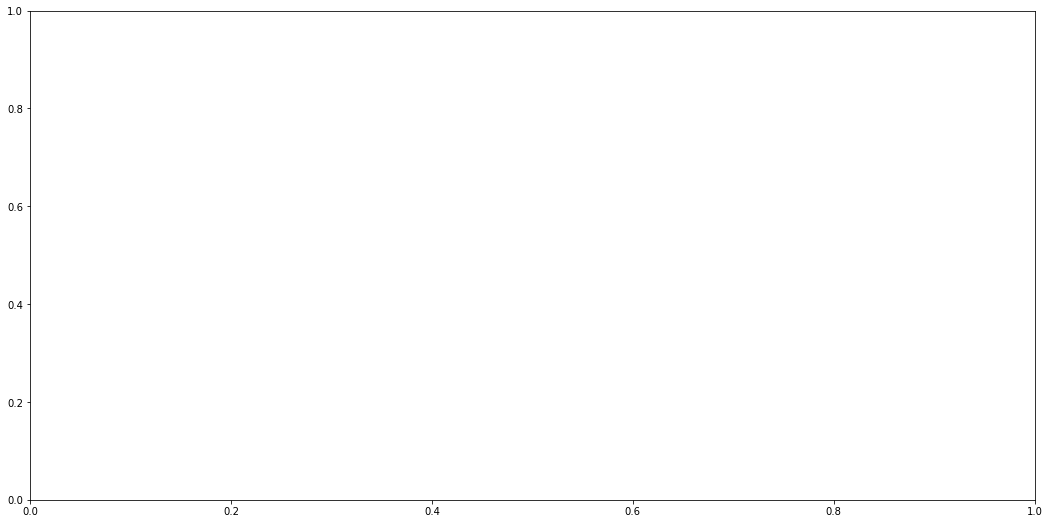

In [119]:
import matplotlib.pyplot as plt
def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);
    
plot_series(df, ['second_diff_mhp'])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

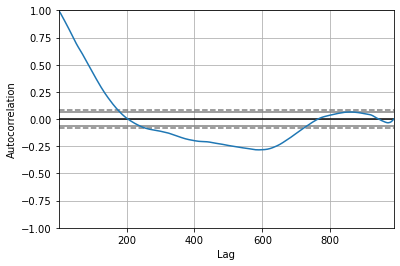

In [103]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)

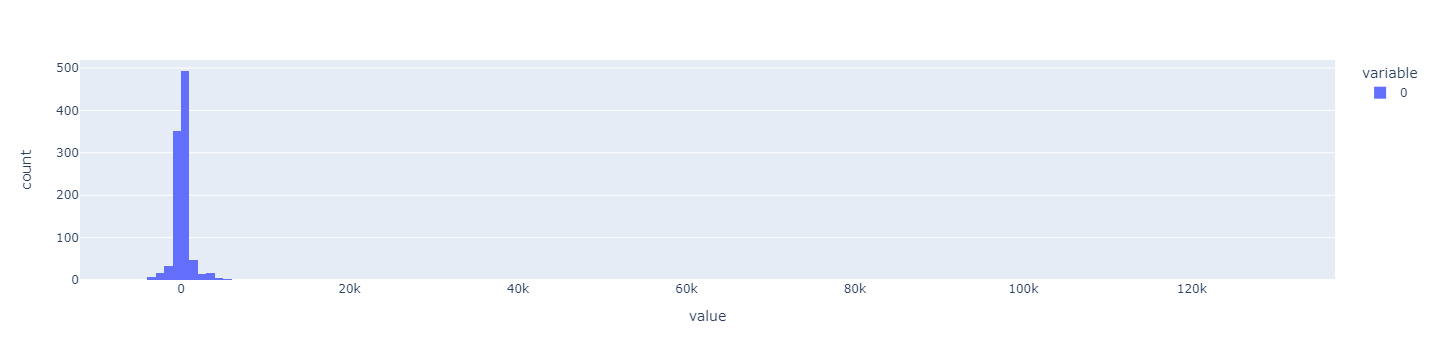

In [100]:
# Parameters
# p = number of lag observations included in the model
# d = number of times that the raw observations are differenced (degree of differencing)
# q = size of moving average window (order of moving average)

model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()

#print(model_fit.summary())

residuals = pd.DataFrame(model_fit.resid)
#residuals.plot()

residual_data = residuals.reset_index()
residual_data.reset_index(inplace = True)

px.line(x = residual_data['index'], y = residual_data[0])

px.histogram(residual_data[0])

C:\Users\Work\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\Work\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



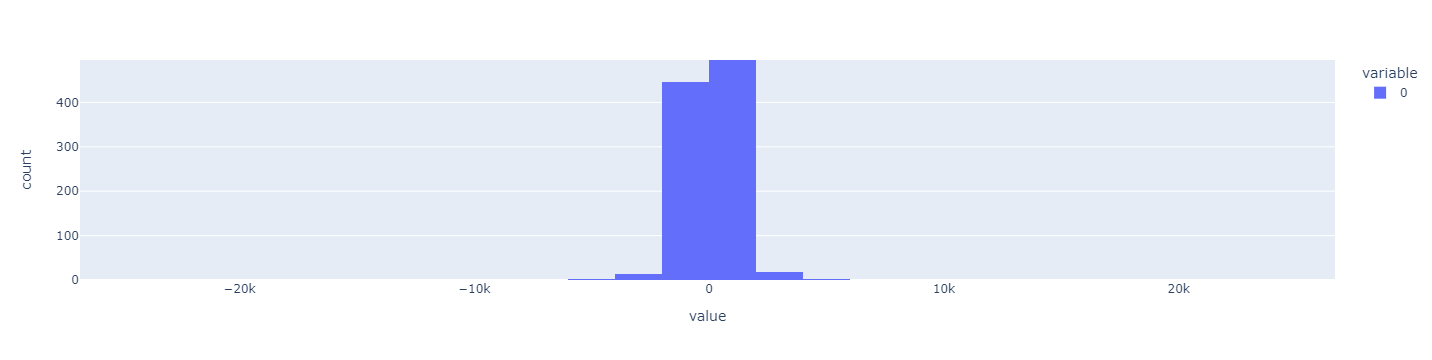

In [102]:
# Parameters
# p = number of lag observations included in the model
# d = number of times that the raw observations are differenced (degree of differencing)
# q = size of moving average window (order of moving average)

model = ARIMA(series, order=(15,5,15))
model_fit = model.fit()

#print(model_fit.summary())

residuals = pd.DataFrame(model_fit.resid)
#residuals.plot()

residual_data = residuals.reset_index()
residual_data.reset_index(inplace = True)

px.line(x = residual_data['index'], y = residual_data[0])

px.histogram(residual_data[0])

## Median Income ARIMA Model

In [123]:
master_table.columns

Index(['FIPS', 'YearID', 'MonthID', 'NewUnits', 'NewBuildings',
       'MedianHousePrice', 'AverageRate', 'AveragePoints', 'Year', 'Month',
       'County', 'AgeGroup', 'MedianIncome'],
      dtype='object')

In [295]:
income_df = master_table[['FIPS','Year','MedianIncome', 'AgeGroup']].copy()
income_df = income_df.dropna()
income_df = income_df[(income_df.FIPS == '34001') & (income_df.AgeGroup == '25-44')]



income_df = income_df[['Year','MedianIncome']]
income_df.drop_duplicates(subset = ['Year'], inplace = True)
income_df['Year'] = income_df['Year'].apply(lambda x: dt.datetime.strptime(str(x), '%Y'))

income_df.set_index('Year', inplace = True)

income_df.index = income_df.index.to_period('Y')
income_df['first_diff_med_income'] = income_df['MedianIncome'].diff()
income_df['second_diff_med_income'] = income_df['MedianIncome'].diff().diff()

In [296]:
adfuller(income_df['MedianIncome'])

(-1.9409253794967736,
 0.3130600699176723,
 0,
 14,
 {'1%': -4.01203360058309,
  '5%': -3.1041838775510207,
  '10%': -2.6909873469387753},
 174.2947764289825)

In [297]:
print(adfuller(income_df['first_diff_med_income'].dropna()))
p_val = adfuller(income_df['first_diff_med_income'].dropna())[1]
print(p_val)

(-5.954910972439216, 2.1044107953091916e-07, 0, 13, {'1%': -4.068853732362312, '5%': -3.1271488757396453, '10%': -2.7017297633136095}, 150.98047009596291)
2.1044107953091916e-07


In [298]:
adfuller(income_df['second_diff_med_income'].dropna())

(-5.432380898083569,
 2.895222693154003e-06,
 1,
 11,
 {'1%': -4.223238279489106,
  '5%': -3.189368925619835,
  '10%': -2.729839421487603},
 160.9528460228513)

In [215]:
#from sklearn.model_selection import GridSearchCV

In [216]:
# Convert dataframe to series for model
#series = income_df[['first_diff_med_income']].squeeze()


In [299]:
X = income_df.reset_index()[['Year']].drop([0])
y = income_df['first_diff_med_income'].dropna()

In [300]:
print(X, y)

    Year
1   2006
2   2007
3   2008
4   2009
5   2010
6   2011
7   2012
8   2013
9   2014
10  2015
11  2016
12  2017
13  2018
14  2019 Year
2006     5542.0
2007     3951.0
2008    -7441.0
2009     7536.0
2010   -11724.0
2011      200.0
2012      942.0
2013     1720.0
2014     1577.0
2015     2317.0
2016     -328.0
2017     8963.0
2018    -3502.0
2019     3313.0
Freq: A-DEC, Name: first_diff_med_income, dtype: float64


In [ ]:

def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

def evaluate_models(df, p_values, d_values, q_values):
    df = df.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(df, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                        print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    
    
evaluate_models(
    income_df['first_diff_med_income'].dropna(),
    [0,1,2,3,4,5,6],
    range(0,3),
    range(0,3)
)

In [226]:
series

Year
2005        NaN
2006     5542.0
2007     3951.0
2008    -7441.0
2009     7536.0
2010   -11724.0
2011      200.0
2012      942.0
2013     1720.0
2014     1577.0
2015     2317.0
2016     -328.0
2017     8963.0
2018    -3502.0
2019     3313.0
Freq: A-DEC, Name: first_diff_med_income, dtype: float64

In [303]:
# Convert dataframe to series for model
series = income_df[['first_diff_med_income']].squeeze()

a_model = ARIMA(series.dropna(), order = (2,1,0))
model_fit = a_model.fit()


In [304]:
from sklearn.model_selection import train_test_split

In [478]:
y_train, y_test = train_test_split(income_df['first_diff_med_income'].dropna(), train_size = .75, shuffle = False)

import matplotlib.pyplot as plt

history = [x for x in y_train]
predictions = list()
# walk-forward validation
for t in range(len(y_test)):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = y_test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(y_test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes

def get_date_range(start_date, period_range, freq):
    
    start_date = dt.datetime.strptime(str(start_date), '%Y')
    date_list = (
        pd.date_range(start=start_date, periods=period_range + 1, freq=freq)
        .to_pydatetime()
        .tolist()
    )
    date_list = [
        str(_.year) for _ in date_list
    ]
    # date_list = [dt.datetime.strptime(f'{_.year}-{_.month}-15', '%Y-%m-%d') for _ in date_list]
    return date_list[1:]
dates = get_date_range(2015, 9, 'Y')


#y_train.index = y_train.index.astype('str')
print(model_fit.forecast(10, alpha = 0.05))
fc, se, conf = model_fit.forecast(10, alpha = 0.05)

fc

predicted=1554.377315, expected=-328.000000
predicted=2299.070974, expected=8963.000000
predicted=-564.411135, expected=-3502.000000
predicted=6635.101841, expected=3313.000000
Test RMSE: 4111.480
[6635.1018412  1097.43418465 2288.02903297 3883.34006114 1274.10054313
 3588.73910713 2193.68816105 2625.43467586 2865.96928564 2333.50880191]


ValueError: too many values to unpack (expected 3)

predicted=1554.377315, expected=-328.000000
predicted=2299.070974, expected=8963.000000
predicted=-564.411135, expected=-3502.000000
predicted=6635.101841, expected=3313.000000
Test RMSE: 4111.480


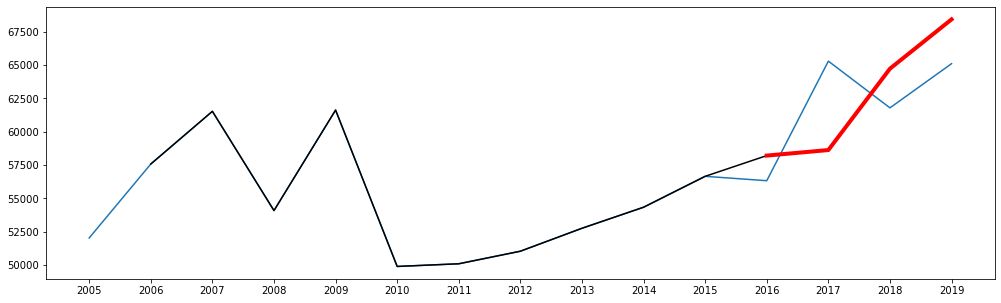

In [476]:
# Create Prediction Dataframe
pred_df = pd.DataFrame(zip(dates, predictions), columns = ['date','Predictions'])
pred_df = pred_df.set_index('date')

# Convert y_train to dataframe from series
y_train = y_train.reset_index()
y_train.set_index('Year', inplace = True)
y_train.rename(columns = {'first_diff_med_income': 'train_set'}, inplace = True)

# Coerce Indexes
y_train.index = y_train.index.astype('str')
pred_df.index = pred_df.index.astype('str')
income_df.index = income_df.index.astype('str')

# Combine DataFrames
combined_df = pd.merge(income_df, pred_df, left_index = True, right_index = True, how = 'outer')
combined_df = pd.merge(combined_df, y_train.dropna(), left_index = True, right_index = True, how = 'outer')
combined_df['Predictions'] = combined_df.Predictions.shift(-1)
combined_df['train_set'] = combined_df.train_set.shift(-1)

def add_rows(target, train, pred):
    if str(train) == 'nan':
        return target + pred
    else:
        return target + train

combined_df['converted'] = combined_df.apply(lambda row: add_rows(row.MedianIncome, row.train_set, row.Predictions), axis = 1)

combined_df['Predictions'] = combined_df['Predictions'] + combined_df['MedianIncome']
combined_df['converted'] = combined_df['converted'].shift(1)
combined_df['Predictions'] = combined_df.Predictions.shift(1)
combined_df['train_set'] = combined_df.train_set.shift(1)

fig = plt.figure(figsize = (17,5))

plt.plot(combined_df['MedianIncome'])
plt.plot(combined_df['converted'], color = 'black')
plt.plot(combined_df['Predictions'], color = 'red', linewidth = 4)
plt.show()

In [490]:
79122+1036


80158

#### income_df

In [252]:
model_fit.plot_predict(dynamic=False)
plt.show()

AttributeError: 'ARIMAResults' object has no attribute 'plot_predict'

In [234]:
# Add a lag
predictions = model_fit.predict(y_train)
predictions

ValueError: Value must be Period, string, integer, or datetime

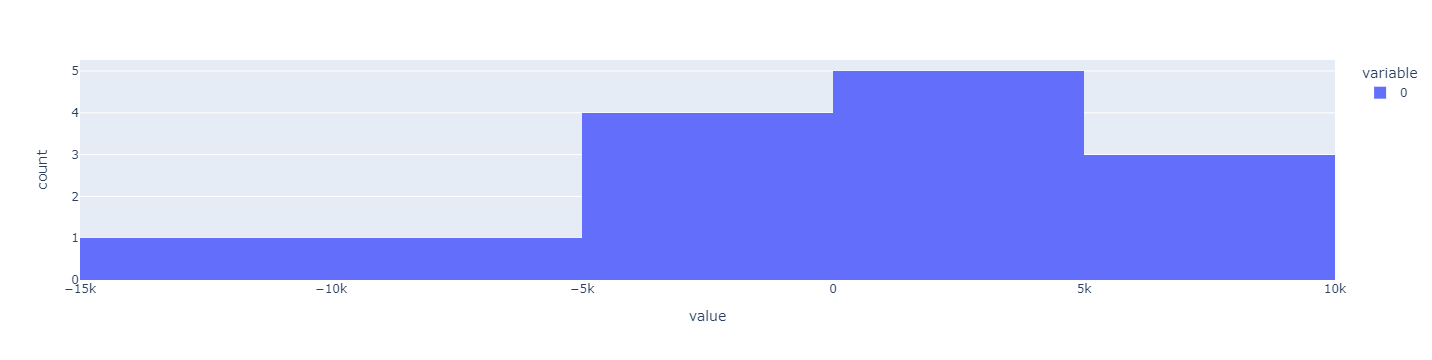

In [224]:
residuals = pd.DataFrame(model_fit.resid)

residual_data = residuals.reset_index()
residual_data.reset_index(inplace = True)

px.line(x = residual_data['index'], y = residual_data[0])

px.histogram(residual_data[0])

In [ ]:
# Parameters
# p = number of lag observations included in the model
# d = number of times that the raw observations are differenced (degree of differencing)
# q = size of moving average window (order of moving average)

model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()

#print(model_fit.summary())

residuals = pd.DataFrame(model_fit.resid)
#residuals.plot()

residual_data = residuals.reset_index()
residual_data.reset_index(inplace = True)

px.line(x = residual_data['index'], y = residual_data[0])

px.histogram(residual_data[0])